# Creation of an autoencoder based on CNN to supress baseline on signals


In [ ]:
%pip install pandas
%pip install tensorflow
%pip install keras
%pip install matplotlib

In [4]:
#@title Libraries needed
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras import utils

In [ ]:
#@title Reading data
data =np.load('example_of_data.npz')

In [ ]:
#@title Observing shape of data
print(data.files)
print(data['X_train'].shape)
print(data['Y_train'].shape)
print(data['X_test'].shape)
print(data['Y_test'].shape)
print(data['arr_0'].shape)
print(data['arr_1'].shape)
print(data['arr_2'].shape)
print(data['arr_3'].shape)

['X_train', 'Y_train', 'X_test', 'Y_test', 'arr_0', 'arr_1', 'arr_2', 'arr_3']
(8000, 400, 1)
(8000, 400, 1)
(2000, 400, 1)
(2000, 400, 1)
(8000, 400, 1)
(8000, 400, 1)
(2000, 400, 1)
(2000, 400, 1)


In [ ]:
#@title Defining each dataset
X_train = data['X_train']
Y_train = data['Y_train']

X_test = data['X_test']
Y_test = data['Y_test']

In [ ]:
#@title Samples vector for plotting
samples = np.arange(1,401,1)

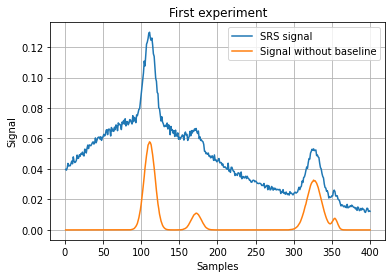

In [ ]:
#@title Plot of the first experiment
data1x = X_train[0][:]
data1y = Y_train[0][:]

#Plot
plt.plot(samples,data1x,label='SRS signal')
plt.plot(samples,data1y,label='Signal without baseline')
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.legend()
plt.grid()
plt.title('First experiment')
plt.savefig('first_experiment.png')

The orange line shows only the peaks we are interested in, without the baseline.

In [ ]:
#@title Creation of the autoencoder
inputs = keras.Input(shape=(400,1),name='Input')

#Encoder
x = keras.layers.Conv1D(128, 3, activation="relu", padding='same',name='First_convolution')(inputs)
x = keras.layers.MaxPooling1D(2,name='First_Pooling')(x)
x = keras.layers.Conv1D(64, 3, activation="relu", padding='same',name='Second_convolution')(x)
x = keras.layers.MaxPooling1D(2,name='Second_Pooling')(x)
x = keras.layers.Conv1D(32, 3, activation="relu", padding='same',name='Third_convolution')(x)
z = keras.layers.MaxPooling1D(2, name='Bottleneck')(x)

#Decoder
x = keras.layers.Conv1DTranspose(32, 3, strides=2, activation="relu", padding='same', name='First_backwards_convolution')(z)
x = keras.layers.Conv1DTranspose(64, 3, strides=2, activation="relu", padding='same', name='Second_backwards_convolution')(x)
x = keras.layers.Conv1DTranspose(128, 3, strides=2, activation="relu", padding='same', name='Thrid_backwards_convolution')(x)
outputs = keras.layers.Conv1D(1, 3, activation="linear", padding='same', name='Output')(x)

autoencoder=keras.Model(inputs=inputs, outputs=outputs,name='Autoencoder')
autoencoder.summary()



Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 400, 1)]          0         
_________________________________________________________________
First_convolution (Conv1D)   (None, 400, 128)          512       
_________________________________________________________________
First_Pooling (MaxPooling1D) (None, 200, 128)          0         
_________________________________________________________________
Second_convolution (Conv1D)  (None, 200, 64)           24640     
_________________________________________________________________
Second_Pooling (MaxPooling1D (None, 100, 64)           0         
_________________________________________________________________
Third_convolution (Conv1D)   (None, 100, 32)           6176      
_________________________________________________________________
Bottleneck (MaxPooling1D)    (None, 50, 32)            

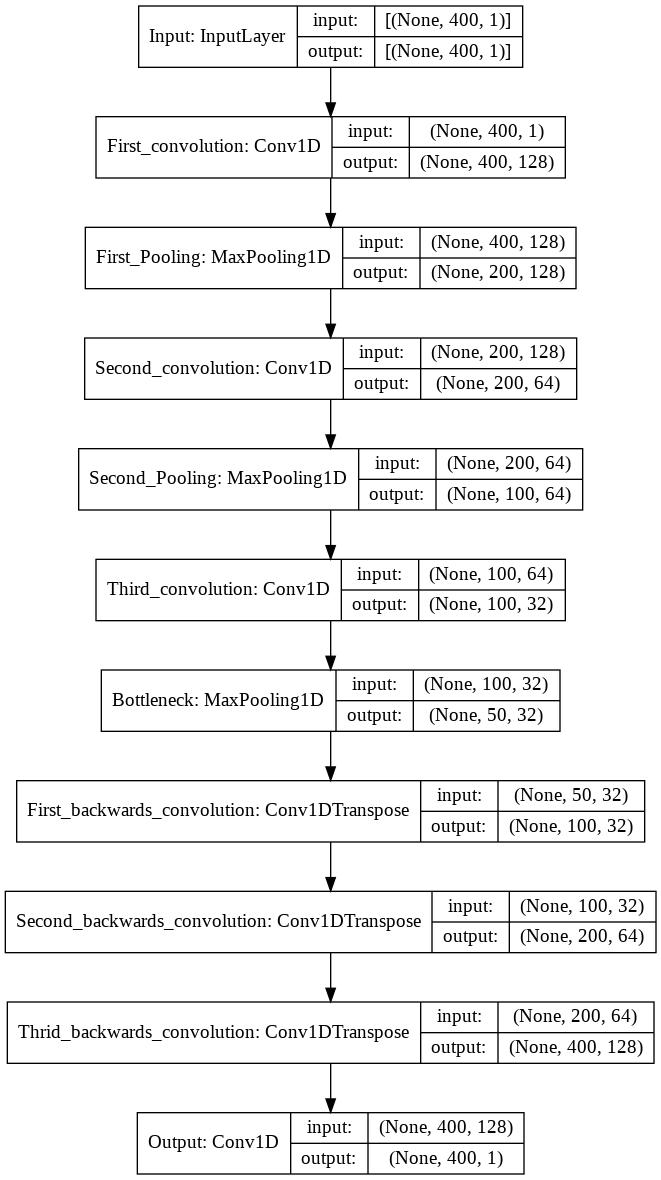

In [ ]:
#@title Diagram of the model
# printout model structure
keras.utils.plot_model(autoencoder, show_shapes=True,to_file='diagram.jpg')

#plt.savefig('diagram.jpg')

In [ ]:
#@title Optimization of the model
# learning rate
LR_ST=1e-3

# Optimizer:
OPTIMIZER = keras.optimizers.Adam(learning_rate=LR_ST)

LOSS = keras.losses.MeanSquaredError()

METRICS = [keras.metrics.MeanAbsoluteError()]

autoencoder.compile(optimizer=OPTIMIZER,
                    loss=LOSS,
                    metrics=METRICS)

In [ ]:
#@title Training of the model
#Callbacks
path_checkpoint = "model_checkpoint"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

callbacks=[es_callback, modelckpt_callback]

# Train the model
history = autoencoder.fit(X_train,Y_train,epochs=100,batch_size=128,
                    validation_split=0.2,shuffle=True,verbose=1, callbacks=callbacks)
 

Epoch 1/100
50/50 [==============================] - 22s 414ms/step - loss: 4.2458e-04 - mean_absolute_error: 0.0092 - val_loss: 1.3716e-04 - val_mean_absolute_error: 0.0051

Epoch 00001: val_loss improved from inf to 0.00014, saving model to model_checkpoint
Epoch 2/100
50/50 [==============================] - 21s 412ms/step - loss: 8.4426e-05 - mean_absolute_error: 0.0044 - val_loss: 5.5776e-05 - val_mean_absolute_error: 0.0035

Epoch 00002: val_loss improved from 0.00014 to 0.00006, saving model to model_checkpoint
Epoch 3/100
50/50 [==============================] - 21s 414ms/step - loss: 5.0201e-05 - mean_absolute_error: 0.0034 - val_loss: 4.2197e-05 - val_mean_absolute_error: 0.0029

Epoch 00003: val_loss improved from 0.00006 to 0.00004, saving model to model_checkpoint
Epoch 4/100
50/50 [==============================] - 21s 414ms/step - loss: 3.8051e-05 - mean_absolute_error: 0.0029 - val_loss: 3.1663e-05 - val_mean_absolute_error: 0.0024

Epoch 00004: val_loss improved from 0

63/63 [==============================] - 2s 30ms/step - loss: 8.5326e-06 - mean_absolute_error: 0.0013
Test loss: 8.53257552080322e-06
Test MAE: 0.0012801727280020714


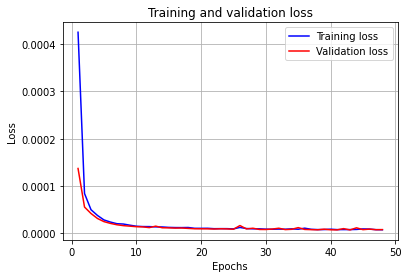

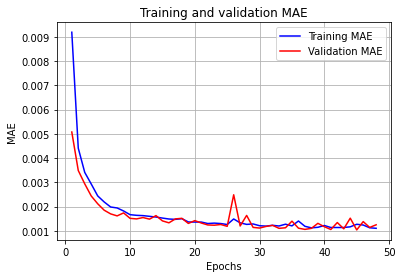

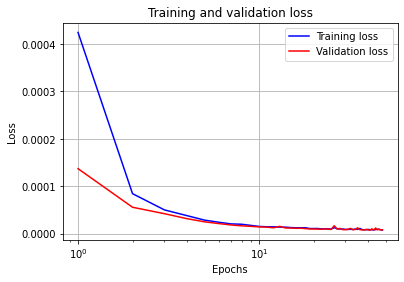

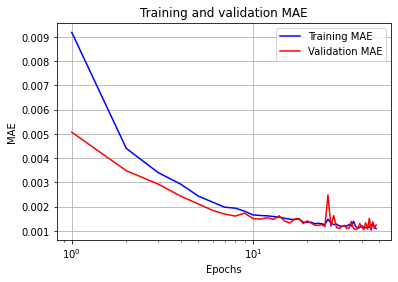

In [ ]:
#@title Study of the loss and MAE

#Extraction of the information from the dictionary
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

MAE_values = history_dict['mean_absolute_error']
val_MAE_values = history_dict['val_mean_absolute_error']

#Number of times the DNN has been run (epochs)
epochs = range(1,len(loss_values)+1)

#Plot of loss and MAE
plt.figure(1)
plt.plot(epochs,loss_values,'b',label='Training loss')
plt.plot(epochs,val_loss_values,'r',label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.grid()
plt.savefig("Loss4.png")

plt.figure(2)
plt.plot(epochs,MAE_values,'b',label='Training MAE')
plt.plot(epochs,val_MAE_values,'r',label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and validation MAE')
plt.grid()
plt.savefig("MAE4.png")

#Logplot of loss and MAE
plt.figure(3)
plt.semilogx(epochs,loss_values,'b',label='Training loss')
plt.semilogx(epochs,val_loss_values,'r',label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.grid()
plt.savefig("Losslog.png")

plt.figure(4)
plt.semilogx(epochs,MAE_values,'b',label='Training MAE')
plt.semilogx(epochs,val_MAE_values,'r',label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and validation MAE')
plt.grid()
plt.savefig("MAElog.png")

#Performance on the test set
test_loss, test_mae = autoencoder.evaluate(X_test,Y_test)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)

We have plotted the losses in a normal scale and in a logarithmic scale in order to simplify the visualization of the error 

(2000, 400, 1)


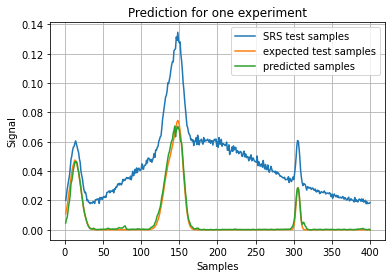

In [ ]:
#@title Predictions on the Test set based on the obtained model
#Predictions
predictions = autoencoder.predict(X_test)
print(predictions.shape)

#Plot of comparison between predictions and actual values
plt.plot(samples,X_test[2][:],label='SRS test samples')
plt.plot(samples,Y_test[2][:],label='expected test samples')
plt.plot(samples,predictions[2][:],label='predicted samples')
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.legend()
plt.grid()
plt.title('Prediction for one experiment')
plt.savefig('prediction4.png')

Now we divide the test set two times in subcategories, depending on the number peaks (the subsets are 1,2,3,4,5 or more than 5 peaks) and the average distance between peaks: that is, we calculate the distances between peaks for each experiment (securing first that number of peaks is greater than one), and then find its mean. This is the average distance. As there can be huge differences between distances for a certain number of peaks, we also find the standard deviation and use it as an errorbar to take in account the fluctuations of our average distances. The categories for this part are: an average distance of:

-50 or less

-between 50 and 100

-between 100 and 150

-between 150 and 200

-between 200 and 250

-between 250 and 300

-between 300 and 350

In [ ]:
#@title Construction of functions for the data split
#Function to finde the maximums of a singal
def Maxfinder(datay,max,ind):
  if datay[j]>0.001:
      if datay[j]>datay[j-1] and datay[j]>datay[j+1]:
        max=np.append(max,datay[j])
        ind=np.append(ind,j)
  return max, ind

#Function for saving the data with a certain number of peaks
def Peaksaver(Xpeak,Ypeak,datax,datay):
  Xpeak=np.append(Xpeak,datax)
  Xpeak=np.reshape(Xpeak,(int(len(Xpeak)/400),400,1))
  Ypeak=np.append(Ypeak,datay)
  Ypeak=np.reshape(Ypeak,(int(len(Ypeak)/400),400,1))
  return Xpeak, Ypeak

#Function to find a vector with the distances between peaks
def Diffvector(ind,diff):
  for i in range(len(ind)-1):
    diff=np.append(diff,abs(ind[i]-ind[i+1]))
  return diff

#Function to save the data with certain average distance
def Diffsaver(Xdiff,Ydiff,error,datax,datay):
  Xdiff=np.append(Xdiff,datax)
  Xdiff=np.reshape(Xdiff,(int(len(Xdiff)/400),400,1))
  Ydiff=np.append(Ydiff,datay)
  Ydiff=np.reshape(Ydiff,(int(len(Ydiff)/400),400,1))
  error=np.append(error,stddiff)
  return Xdiff, Ydiff, error

In [ ]:
#@title Preparing data for comparison of height and distance between peaks
#Vector for the peaks
Xpeak1=np.zeros(0)
Xpeak2=np.zeros(0)
Xpeak3=np.zeros(0)
Xpeak4=np.zeros(0)
Xpeak5=np.zeros(0)
Xpeakother=np.zeros(0)

Ypeak1=np.zeros(0)
Ypeak2=np.zeros(0)
Ypeak3=np.zeros(0)
Ypeak4=np.zeros(0)
Ypeak5=np.zeros(0)
Ypeakother=np.zeros(0)

#Vector for the differences
Xdiff50=np.zeros(0)
Xdiff100=np.zeros(0)
Xdiff150=np.zeros(0)
Xdiff200=np.zeros(0)
Xdiff250=np.zeros(0)
Xdiff300=np.zeros(0)
Xdiff350=np.zeros(0)

Ydiff50=np.zeros(0)
Ydiff100=np.zeros(0)
Ydiff150=np.zeros(0)
Ydiff200=np.zeros(0)
Ydiff250=np.zeros(0)
Ydiff300=np.zeros(0)
Ydiff350=np.zeros(0)

#The errors to take in account the std of the distances
error50=np.zeros(0)
error100=np.zeros(0)
error150=np.zeros(0)
error200=np.zeros(0)
error250=np.zeros(0)
error300=np.zeros(0)
error350=np.zeros(0)

#Program to find the maximums and classify them in function of 
#the number of peaks and distance between peaks
for i in range(2000):  
  datay = Y_test[i][:]
  datay = np.reshape(datay,400)

  datax = X_test[i][:]

  max=np.zeros(0)
  ind=np.zeros(0)
  diff=np.zeros(0)

  for j in range(1,len(datay)-1):   
    max, ind = Maxfinder(datay,max,ind)
  if len(max)==1:
    Xpeak1,Ypeak1 = Peaksaver(Xpeak1,Ypeak1,datax,datay)
  else:
    diff = Diffvector(ind,diff)
    meandiff=np.mean(diff)
    stddiff=np.std(diff)
    if len(max)==2:
      Xpeak2,Ypeak2 = Peaksaver(Xpeak2,Ypeak2,datax,datay)
    elif len(max)==3:
      Xpeak3,Ypeak3 = Peaksaver(Xpeak3,Ypeak3,datax,datay)
    elif len(max)==4:
      Xpeak4,Ypeak4 = Peaksaver(Xpeak4,Ypeak4,datax,datay)
    elif len(max)==5:
      Xpeak5,Ypeak5 = Peaksaver(Xpeak5,Ypeak5,datax,datay)
    else:
      Xpeakother,Ypeakother = Peaksaver(Xpeakother,Ypeakother,datax,datay)
    if meandiff<50:
      Xdiff50, Ydiff50, error50 = Diffsaver(Xdiff50,Ydiff50,error50,datax,datay)
    elif meandiff<100:
      Xdiff100, Ydiff100, error100 = Diffsaver(Xdiff100,Ydiff100,error100,datax,datay)
    elif meandiff<150:
      Xdiff150, Ydiff150, error150 = Diffsaver(Xdiff150,Ydiff150,error150,datax,datay)
    elif meandiff<200:
      Xdiff200, Ydiff200, error200 = Diffsaver(Xdiff200,Ydiff200,error200,datax,datay)
    elif meandiff<250:
      Xdiff250, Ydiff250, error250 = Diffsaver(Xdiff250,Ydiff250,error250,datax,datay)
    elif meandiff<300:
      Xdiff300, Ydiff300, error300 = Diffsaver(Xdiff300,Ydiff300,error300,datax,datay)
    elif meandiff<350:
      Xdiff350, Ydiff350, error350 = Diffsaver(Xdiff350,Ydiff350,error350,datax,datay)

In [ ]:
#Observing the dimensions of our obtained vectors
print('Xpeak:')
print(Xpeak1.shape)
print(Xpeak2.shape)
print(Xpeak3.shape)
print(Xpeak4.shape)
print(Xpeak5.shape)
print(Xpeakother.shape)

print('Ypeak:')
print(Ypeak1.shape)
print(Ypeak2.shape)
print(Ypeak3.shape)
print(Ypeak4.shape)
print(Ypeak5.shape)
print(Ypeakother.shape)

print('Xdiff')
print(Xdiff50.shape)
print(Xdiff100.shape)
print(Xdiff150.shape)
print(Xdiff200.shape)
print(Xdiff250.shape)
print(Xdiff300.shape)
print(Xdiff350.shape)

print('Ydiff')
print(Ydiff50.shape)
print(Ydiff100.shape)
print(Ydiff150.shape)
print(Ydiff200.shape)
print(Ydiff250.shape)
print(Ydiff300.shape)
print(Ydiff350.shape)

Xpeak:
(357, 400, 1)
(364, 400, 1)
(327, 400, 1)
(364, 400, 1)
(277, 400, 1)
(311, 400, 1)
Ypeak:
(357, 400, 1)
(364, 400, 1)
(327, 400, 1)
(364, 400, 1)
(277, 400, 1)
(311, 400, 1)
Xdiff
(392, 400, 1)
(788, 400, 1)
(277, 400, 1)
(100, 400, 1)
(37, 400, 1)
(35, 400, 1)
(14, 400, 1)
Ydiff
(392, 400, 1)
(788, 400, 1)
(277, 400, 1)
(100, 400, 1)
(37, 400, 1)
(35, 400, 1)
(14, 400, 1)


We evaluate the performance of our model in each subset of the Test set in order to see if there is any special preference or difficulty for certain cases. We first do this for the number of peaks, then for the average distance between peaks.

12/12 [==============================] - 0s 30ms/step - loss: 4.3037e-06 - mean_absolute_error: 7.5156e-04
Test loss: 4.303698915464338e-06
Test MAE: 0.0007515643374063075
12/12 [==============================] - 0s 29ms/step - loss: 6.2945e-06 - mean_absolute_error: 9.8737e-04
Test loss: 6.294483227975434e-06
Test MAE: 0.0009873706148937345
11/11 [==============================] - 0s 29ms/step - loss: 8.9356e-06 - mean_absolute_error: 0.0013
Test loss: 8.935645382734947e-06
Test MAE: 0.0012641840148717165
12/12 [==============================] - 0s 30ms/step - loss: 9.9914e-06 - mean_absolute_error: 0.0015
Test loss: 9.991385013563558e-06
Test MAE: 0.001481656450778246
9/9 [==============================] - 0s 30ms/step - loss: 1.1214e-05 - mean_absolute_error: 0.0016
Test loss: 1.1213513971597422e-05
Test MAE: 0.0016276497626677155
10/10 [==============================] - 0s 30ms/step - loss: 1.1487e-05 - mean_absolute_error: 0.0017
Test loss: 1.1487377378216479e-05
Test MAE: 0.00170

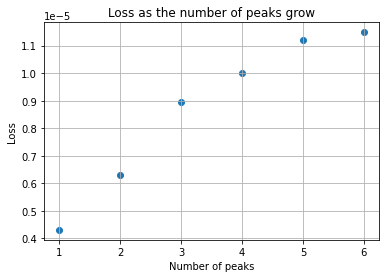

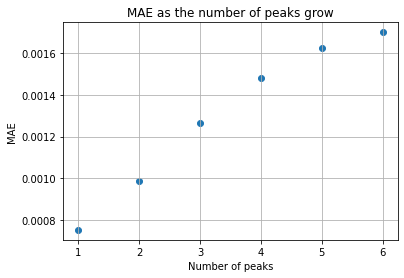

In [ ]:
#@title Performance of the model for each number of peaks
#Performance on each test set
loss_peak=[]
MAE_peak=[]

#1 peak
test_loss, test_mae = autoencoder.evaluate(Xpeak1,Ypeak1)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_peak.append(test_loss)
MAE_peak.append(test_mae)

#2 peaks
test_loss, test_mae = autoencoder.evaluate(Xpeak2,Ypeak2)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_peak.append(test_loss)
MAE_peak.append(test_mae)

#3 peaks
test_loss, test_mae = autoencoder.evaluate(Xpeak3,Ypeak3)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_peak.append(test_loss)
MAE_peak.append(test_mae)

#4 peaks
test_loss, test_mae = autoencoder.evaluate(Xpeak4,Ypeak4)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_peak.append(test_loss)
MAE_peak.append(test_mae)

#5 peaks
test_loss, test_mae = autoencoder.evaluate(Xpeak5,Ypeak5)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_peak.append(test_loss)
MAE_peak.append(test_mae)

#more peaks
test_loss, test_mae = autoencoder.evaluate(Xpeakother,Ypeakother)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_peak.append(test_loss)
MAE_peak.append(test_mae)

#plot
x=np.arange(1,7,1)

plt.figure(1)
plt.scatter(x,loss_peak)
plt.xlabel('Number of peaks')
plt.ylabel('Loss')
plt.title('Loss as the number of peaks grow')
plt.grid()
plt.savefig('Losspeak4.jpg')

plt.figure(2)
plt.scatter(x,MAE_peak)
plt.xlabel('Number of peaks')
plt.ylabel('MAE')
plt.title('MAE as the number of peaks grow')
plt.grid()
plt.savefig('MAEpeak4.jpg')

(327, 400, 1)


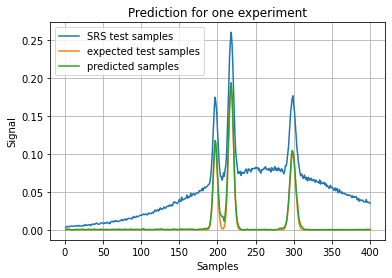

In [ ]:
#@title Example of prediction for the dependance on the number of peaks
#Predictions
predictions = autoencoder.predict(Xpeak3)
print(predictions.shape)

#Plot of comparison between predictions and actual values
plt.plot(samples,Xpeak3[1][:],label='SRS test samples')
plt.plot(samples,Ypeak3[1][:],label='expected test samples')
plt.plot(samples,predictions[1][:],label='predicted samples')
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.legend()
plt.grid()
plt.title('Prediction for one experiment')
plt.savefig('prediction.png')

13/13 [==============================] - 0s 29ms/step - loss: 1.2401e-05 - mean_absolute_error: 0.0015
Test loss: 1.240090023202356e-05
Test MAE: 0.001524022314697504
25/25 [==============================] - 1s 31ms/step - loss: 9.5975e-06 - mean_absolute_error: 0.0015
Test loss: 9.597489224688616e-06
Test MAE: 0.0014773033326491714
9/9 [==============================] - 0s 30ms/step - loss: 7.5990e-06 - mean_absolute_error: 0.0012
Test loss: 7.598950105602853e-06
Test MAE: 0.0012205849634483457
4/4 [==============================] - 0s 24ms/step - loss: 5.3994e-06 - mean_absolute_error: 0.0011
Test loss: 5.399435849540168e-06
Test MAE: 0.00106442766264081
2/2 [==============================] - 0s 14ms/step - loss: 5.6208e-06 - mean_absolute_error: 0.0010
Test loss: 5.620763204206014e-06
Test MAE: 0.0010196667863056064
2/2 [==============================] - 0s 13ms/step - loss: 5.0431e-06 - mean_absolute_error: 9.9160e-04
Test loss: 5.043112651037518e-06
Test MAE: 0.000991595908999443


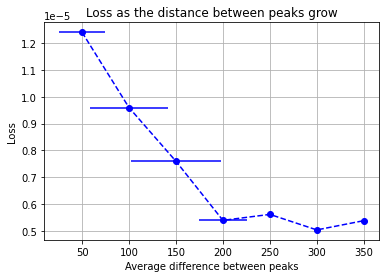

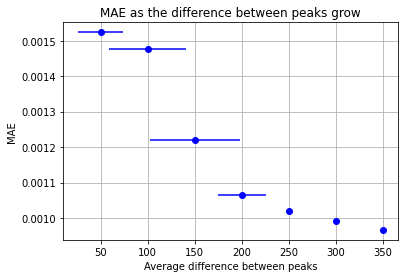

In [ ]:
#@title Performance of the model for the difference between peaks
#Performance on each test set
loss_diff=[]
MAE_diff=[]

#<50
test_loss, test_mae = autoencoder.evaluate(Xdiff50,Ydiff50)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_diff.append(test_loss)
MAE_diff.append(test_mae)

#<100
test_loss, test_mae = autoencoder.evaluate(Xdiff100,Ydiff100)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_diff.append(test_loss)
MAE_diff.append(test_mae)

#<150
test_loss, test_mae = autoencoder.evaluate(Xdiff150,Ydiff150)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_diff.append(test_loss)
MAE_diff.append(test_mae)

#<200
test_loss, test_mae = autoencoder.evaluate(Xdiff200,Ydiff200)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_diff.append(test_loss)
MAE_diff.append(test_mae)

#<250
test_loss, test_mae = autoencoder.evaluate(Xdiff250,Ydiff250)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_diff.append(test_loss)
MAE_diff.append(test_mae)

#<300
test_loss, test_mae = autoencoder.evaluate(Xdiff300,Ydiff300)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_diff.append(test_loss)
MAE_diff.append(test_mae)

#<350
test_loss, test_mae = autoencoder.evaluate(Xdiff350,Ydiff350)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)
loss_diff.append(test_loss)
MAE_diff.append(test_mae)

#plot
x=np.arange(50,400,50)

plt.figure(1)
plt.errorbar(x,loss_diff,xerr=errorvec,fmt='o',color='blue',linestyle='--')
plt.xlabel('Average difference between peaks')
plt.ylabel('Loss')
plt.title('Loss as the distance between peaks grow')
plt.grid()
plt.savefig('Lossdiff4.jpg')

plt.figure(2)
plt.errorbar(x,MAE_diff,xerr=errorvec,fmt='o',color='blue',linestyle=' ')
plt.xlabel('Average difference between peaks')
plt.ylabel('MAE')
plt.title('MAE as the difference between peaks grow')
plt.grid()
plt.savefig('MAEdiff4.jpg')

(788, 400, 1)


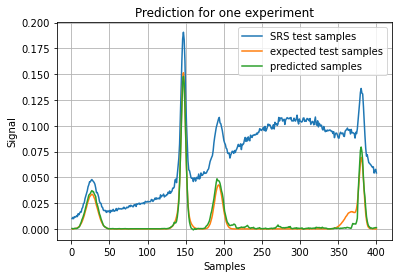

In [ ]:
#@title Example of prediction for the dependance on the difference between peaks
#Predictions
predictions = autoencoder.predict(Xdiff100)
print(predictions.shape)

#Plot of comparison between predictions and actual values
plt.plot(samples,Xdiff100[3][:],label='SRS test samples')
plt.plot(samples,Ydiff100[3][:],label='expected test samples')
plt.plot(samples,predictions[3][:],label='predicted samples')
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.legend()
plt.grid()
plt.title('Prediction for one experiment')
plt.savefig('prediction2.png')